Time series analysis can be used for forecasting a quantity into the future and are usually used in business applications
Objectives of time series analysis are:

* examine the series 
* extract the seasonality component
* choose the best ARIMA model
* forecast

In [1]:
library(readr)
library(tseries)
library(forecast)

In [2]:
list.files("../input/exchange.csv")

character(0)

Dataset:

* foreign exchange rate RUB/USD from July 1997 to December 2015

In [3]:
mydata<- read.csv("../input/exchange.csv",sep=";")
head(mydata)

DATE,BRL.USD,RUB.USD,INR.USD,YUAN.USD
01/07/1997,1.0857,5.81631,35.9407,8.3395
01/08/1997,1.0880,5.82318,35.7092,8.2996
01/09/1997,1.0927,5.85338,36.4445,8.2858
01/10/1997,1.0941,5.85263,36.0734,8.2524
01/11/1997,1.1090,5.91892,37.0190,8.2940
01/12/1997,1.1174,5.95702,39.2366,8.3140


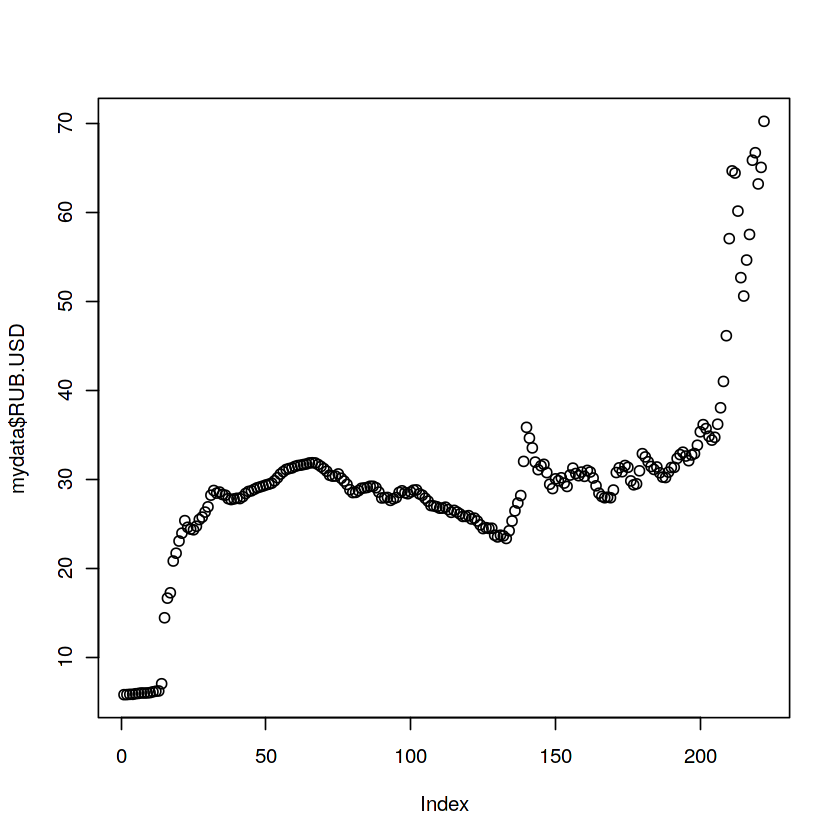

In [4]:
plot(mydata$RUB.USD)

ts() command create a time series object

In [5]:
timeseries=ts(mydata[,c('RUB.USD')])
mydata$RUB.USD=tsclean(timeseries)

decomposition of time series

* it calculate the seasonal component using smoothing and then adjust the original series for seasonality. The result is a seasonality adjusted time series

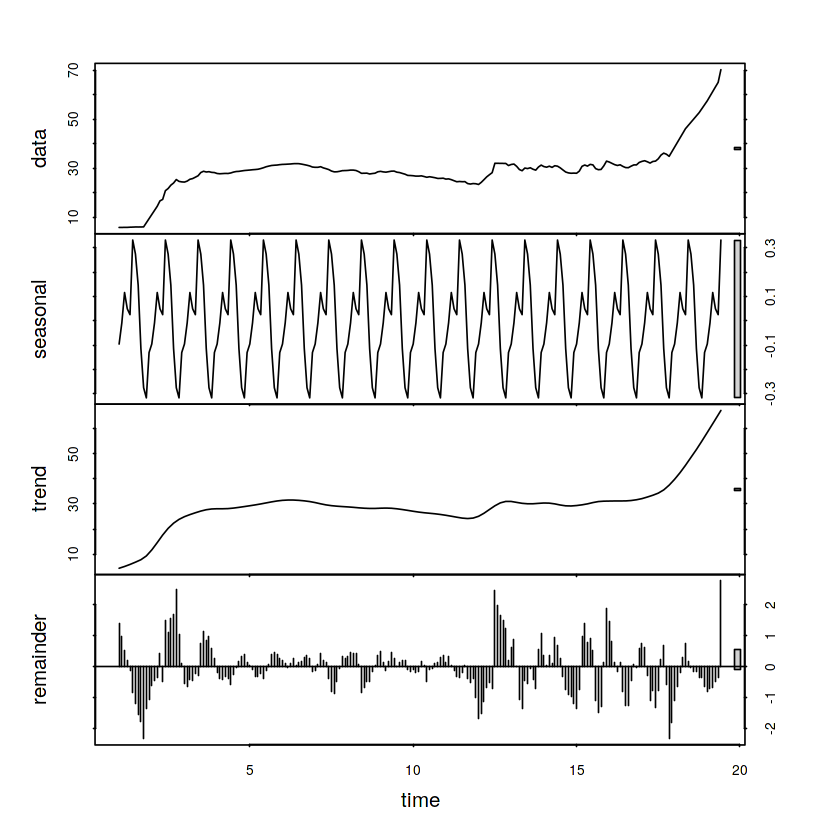

In [6]:
count_ts=ts(na.omit(mydata$RUB.USD), frequency=12)
decomp=stl(count_ts, s.window = "periodic")
deseasonal_ts<-seasadj(decomp)
plot(decomp)

**Stationarity test**

* augmented Dickey-Fuller test for stationarity/ non-stationarity of data.  
A large p-value(>0.05) suggests that the time serie is non-stationary (Accept H0 hypotesis)

* Kwiatkowski-Phillips-Schmidt-Shin test of stationarity. 
In this case, if p-value are smaller then 5% differencing is required => for KPSS test H0:stationarity; H1:non-stationarity 


In [7]:

adf<-adf.test(count_ts, alternative = "stationary")
kpss=kpss.test(count_ts)
adf
kpss

Warning message in adf.test(count_ts, alternative = "stationary"):
“p-value greater than printed p-value”Warning message in kpss.test(count_ts):
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  count_ts
Dickey-Fuller = 0.33405, Lag order = 6, p-value = 0.99
alternative hypothesis: stationary



	KPSS Test for Level Stationarity

data:  count_ts
KPSS Level = 2.4691, Truncation lag parameter = 3, p-value = 0.01


Plot Acf and Pacf 

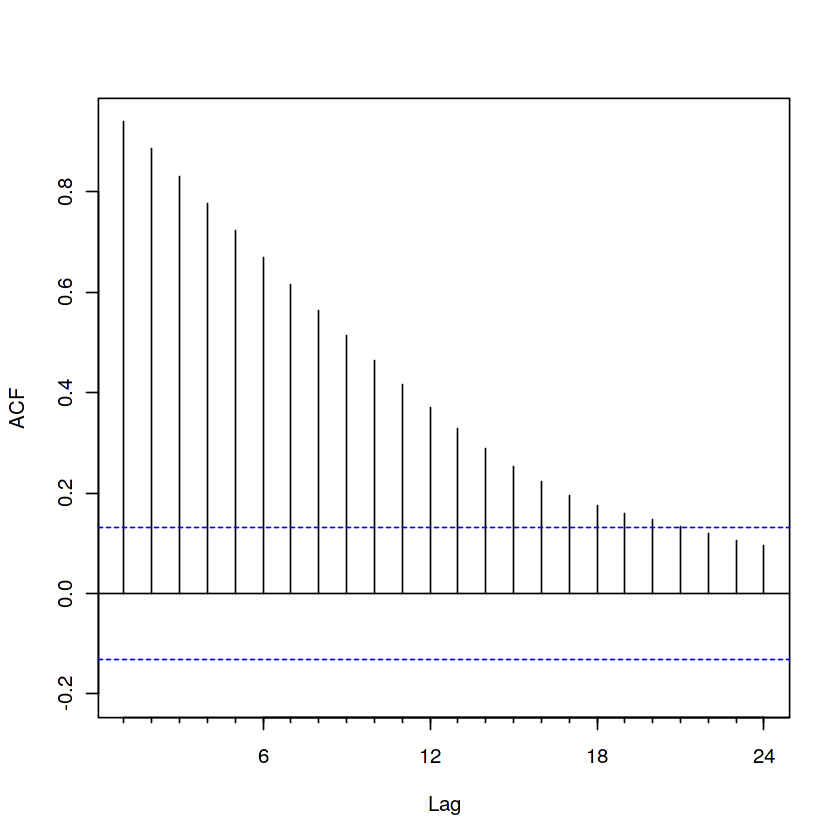

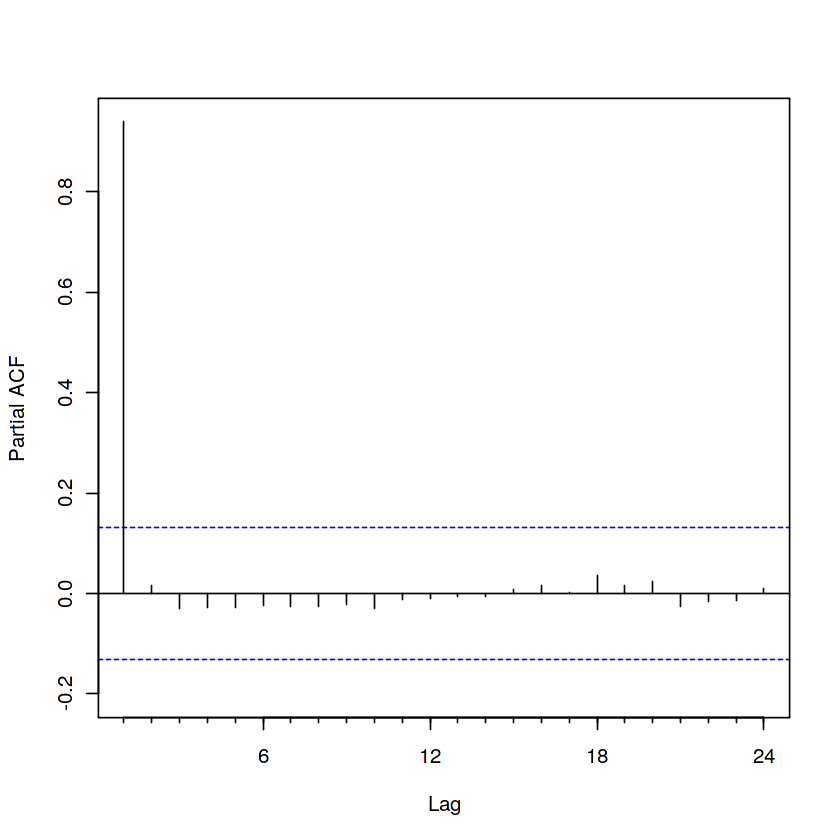

In [8]:
Acf(count_ts, main='')
Pacf(count_ts, main='')

Results of Adf and Kpss test showed that the time series is not stationarity.

In [9]:
#differencing data d=1
ts_d1=diff(deseasonal_ts, differences=1)


	Augmented Dickey-Fuller Test

data:  ts_d1
Dickey-Fuller = -1.8826, Lag order = 6, p-value = 0.6252
alternative hypothesis: stationary


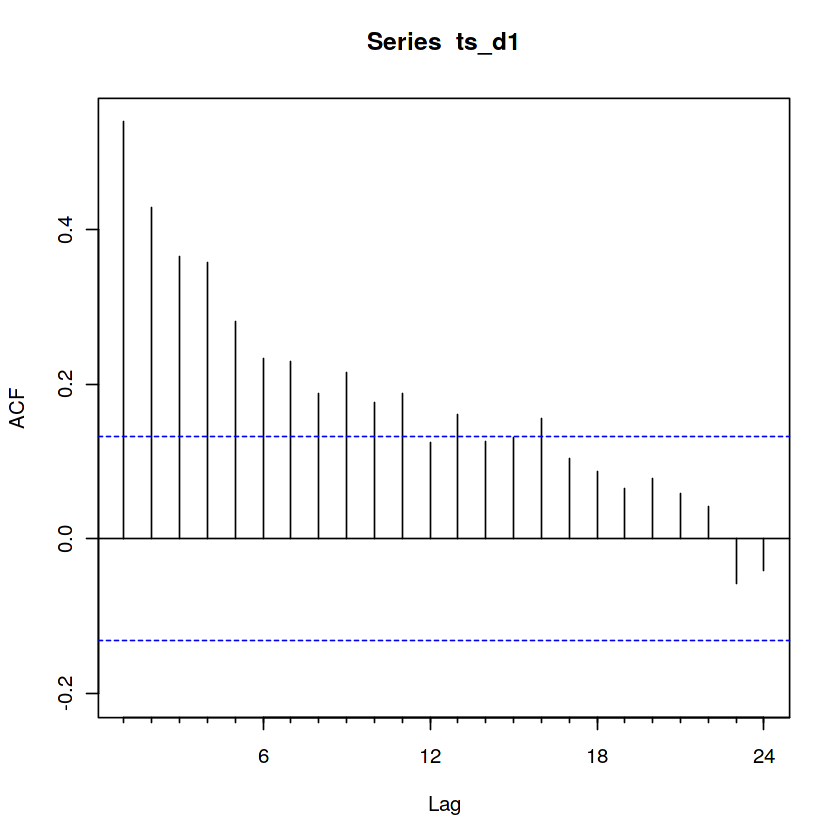

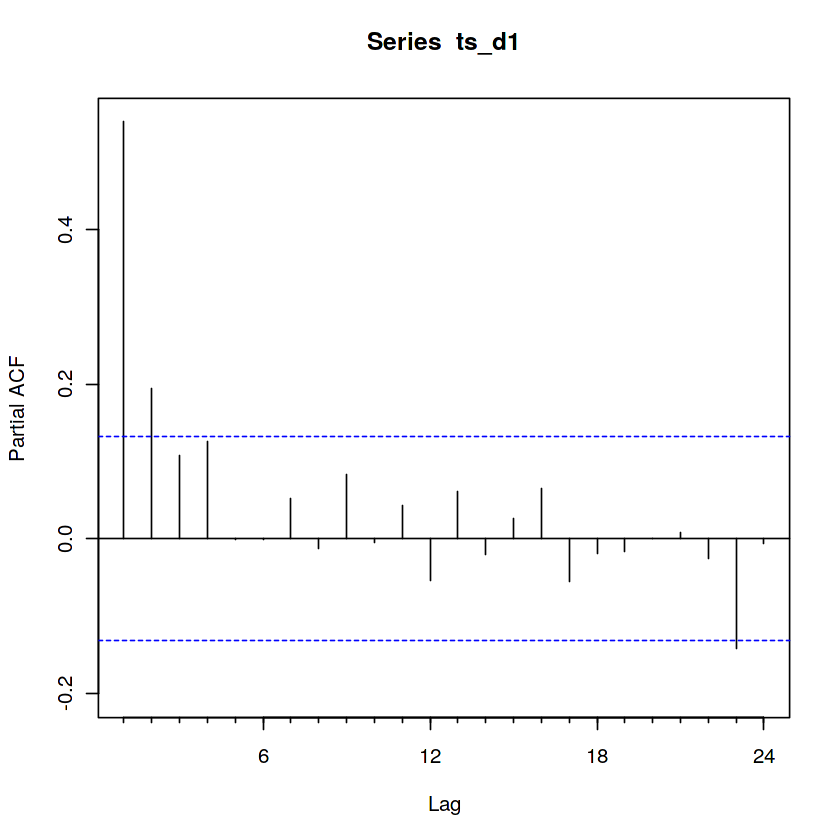

In [10]:
#stationary test for d=1
adfd1<-adf.test(ts_d1, alternative = "stationary")
adfd1
Acf(ts_d1)
Pacf(ts_d1)

In [11]:
#differencing data d=2
ts_d2=diff(ts_d1, differences=1)

Warning message in adf.test(ts_d2, alternative = "stationary"):
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  ts_d2
Dickey-Fuller = -7.1562, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


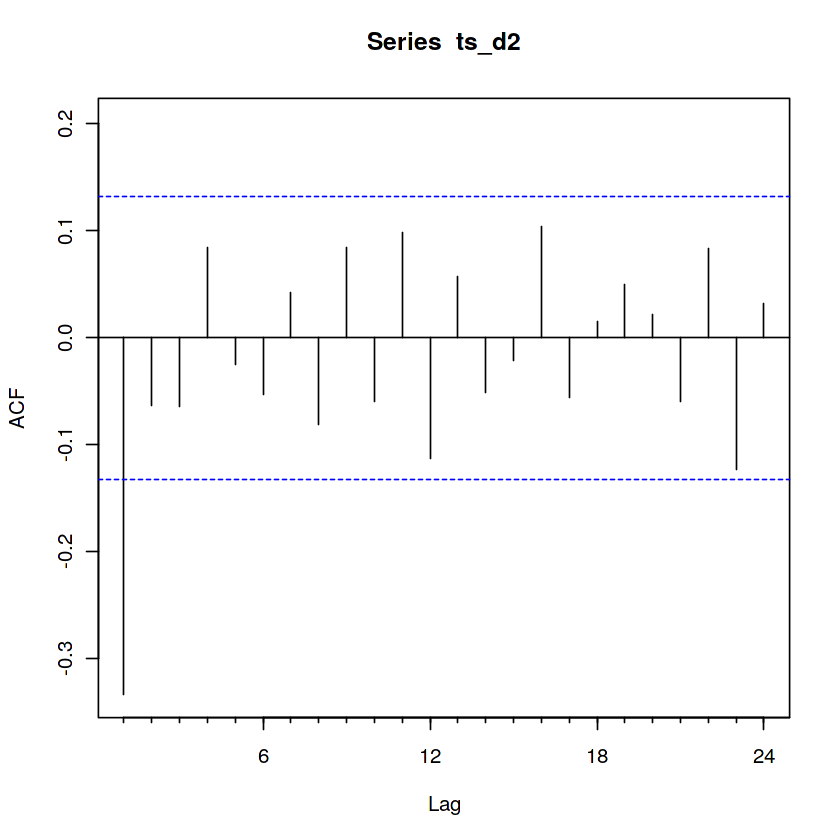

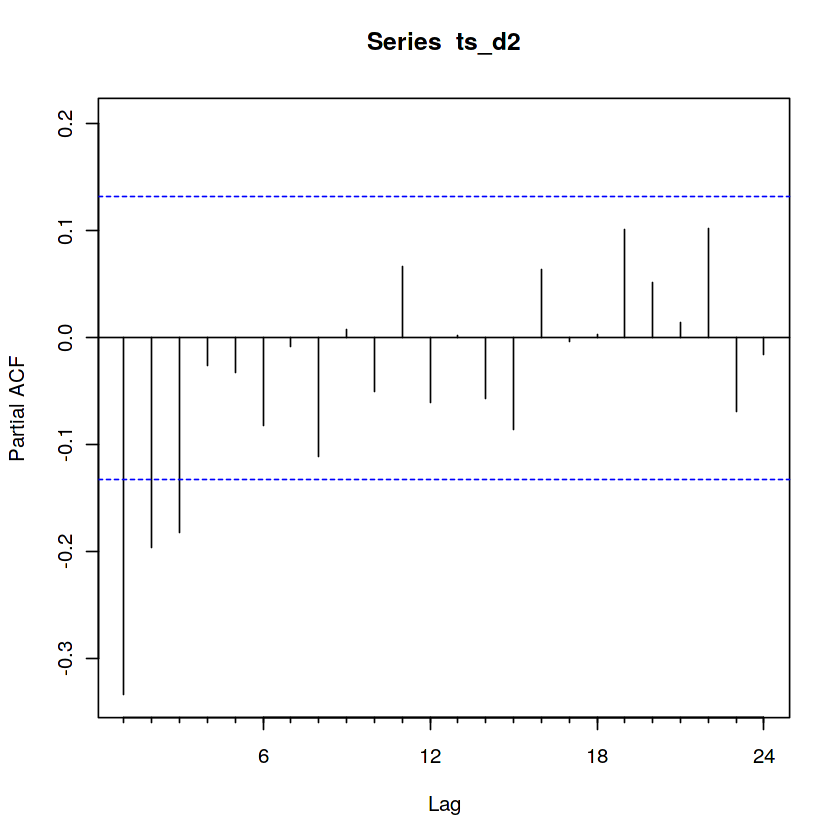

In [12]:
#stationary test for d=2
adfd2<-adf.test(ts_d2, alternative = "stationary")
adfd2
Acf(ts_d2)
Pacf(ts_d2)

**Fit the ARIMA model.**

ARIMA stands for auto-regressive integrated moving average and is specified by these three order parameters: (p, d, q).

AR(p), is referring to the use of past values in the regression equation for the series Y. The auto-regressive parameter p specifies the number of lags used in the model.

I(d) The d represents the degree of differencing

MA(q) component represents the error of the model as a combination of previous error terms. The order q determines the number of terms to include in the model

auto.arima() command choose the best ARIMA model

In [13]:
#fitting the model
model1<-auto.arima(deseasonal_ts, seasonal = F)
model1

Series: deseasonal_ts 
ARIMA(2,2,3)                               

Coefficients:
          ar1     ar2      ma1      ma2     ma3
      -0.1194  0.3043  -0.4281  -0.4717  0.0829
s.e.   0.7994  0.5057   0.8165   0.7131  0.3701

sigma^2 estimated as 0.4445:  log likelihood=-220.81
AIC=453.62   AICc=454.02   BIC=473.98

Evaluate the model for forecast.

we would expect no significant autocorrelations present in the model residuals.
 

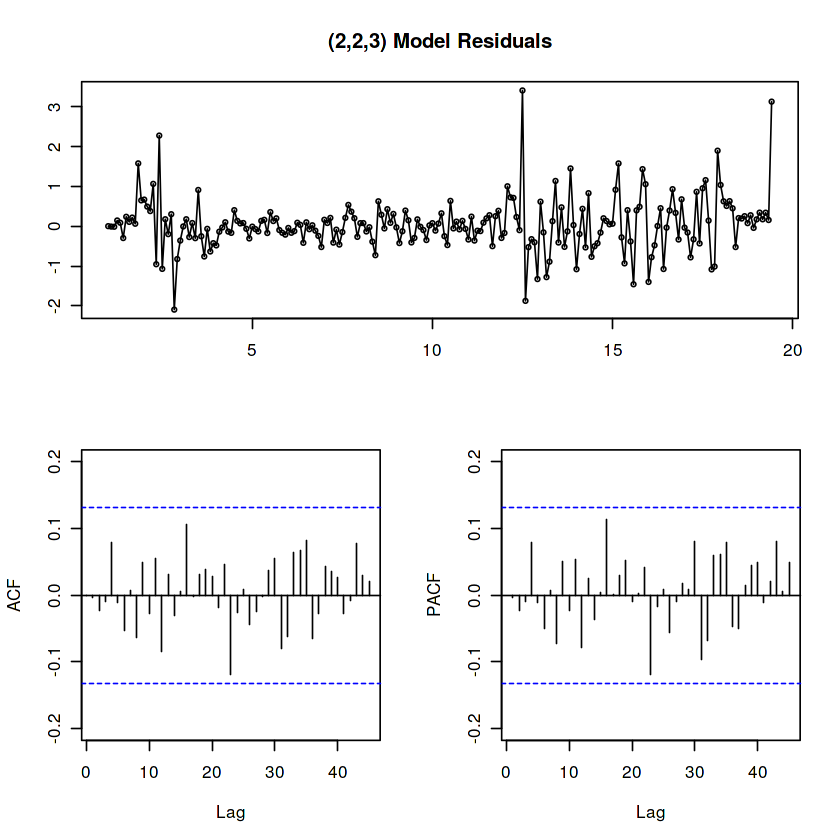

In [14]:
tsdisplay(residuals(model1), lag.max=45, main='(2,2,3) Model Residuals')

Forecasting

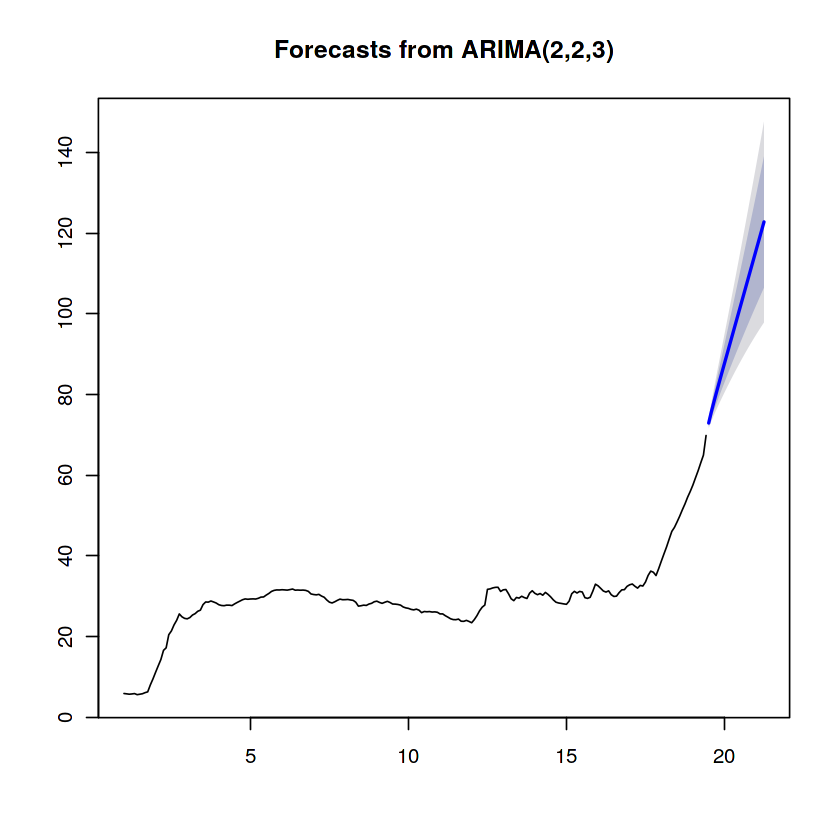

In [15]:
fcast<-forecast(model1, h=22)
plot(fcast)

Validate the forecast with " hold-out" method

[1] 222

[1] 23

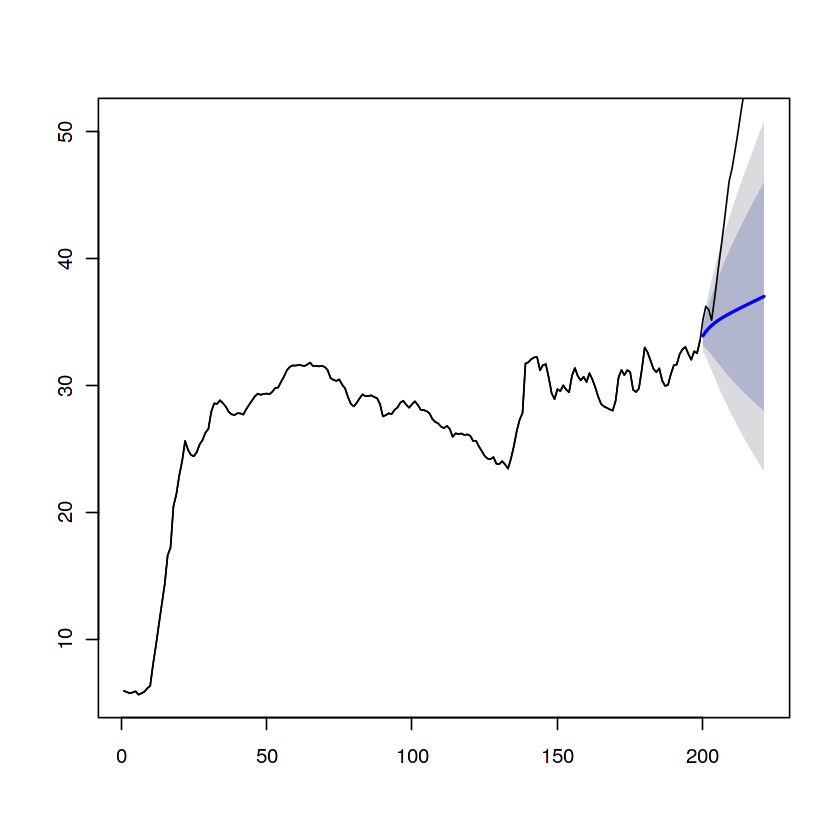

In [16]:
length(deseasonal_ts)

hold<-window(ts(deseasonal_ts), start=200)

length(hold)

fit_no_hold= arima(ts(deseasonal_ts[-c(200:222)]), order=c(2,2,3))
fcast_no_hold<-forecast(fit_no_hold,h=22)
plot(fcast_no_hold, main=" ")
lines(ts(deseasonal_ts))